## Smoothing the timeseries using Gaussian Processes

The goal of this notebook is to run GPs on the eigenvalues for the most significant components identified by PCA. This is done with the `celerite` package, using MCMC (implemented by `emcee`) to optimise the parameters.

The kernel used in this analysis is the Matern-3/2, which only has the amplitude and length scale as independent variables. (There are also a constant and white noise term which will be optimised by the MCMC.) The bounds on the length scale can be derived from the input data: the minimum bound is set to the 99.5th percentile of the separation of observations (so that the GP will not latch onto inter-observation variations), and the maximum is set to half the observed timespan.

The calculations inside `celerite` are performed in log-space, so the chains and distributions plotted for each component must be interpreted as such.

Once the GPs have been run for your selected number of significant components (typically between 2 and 5), a plot will be made showing, for each component, the input eigenvalues over time overlaid with the predictions using the GP median values with uncertainties. This plot is valuable for determining if the GP has succeeded in modeling the eigenvalues for each component. 

Finally, a waterfall plot showing the reconstructed (mean-subtracted) profiles is made, which is a useful tool for visualising the smoothed profile variations. 


In [1]:
%load_ext autoreload


In [2]:
import os, sys
import numpy as np
from matplotlib import pyplot as plt
import cmasher as cmr
import corner    
import multiprocessing as mpr
mpr.set_start_method('fork')
#import gp_init_threads as th_init
from all_prof_functions import (run_each_gp, plot_recon_profs)

%aimport -os -np -plt -cmr -mpr -corner
%autoreload 2


In [3]:
# Set up some plotting stuff
plt.rc('savefig', bbox='tight')
use_bk_bgd = False #### Change this to switch between dark and light backgrounds for plots (True == dark) #####
if use_bk_bgd:
    plot_style = 'dark_background'
    # The CMasher package provides lots of lovely colour maps; chroma is a handy sequential cmap
    cmap = cmr.chroma_r
    c1 = cmap(0.0)
    c2 = cmap(0.1)
    c3 = cmap(0.33)
    c4 = cmap(0.55)
    c5 = cmap(0.68)
    c6 = cmap(0.815)

else:
    plot_style = 'default'
    cmap = cmr.chroma
    c1 = cmap(0.0)
    c2 = cmap(0.3)
    c3 = cmap(0.53)
    c4 = cmap(0.65)
    c5 = cmap(0.78)
    c6 = cmap(0.915)


The following cell contains variables describing the dataset and where the data are located. Change them as needed. 

In [4]:
data_dir = '/home/s86932rs/research/nudot_stuff/'
plots_dir = os.path.join(data_dir, 'plots')
psr = 'B1540-06'
freq = 1400
be = 'dfb'


In [5]:
be = be.lower()
BE = be.upper()
desc = "{}_{}_{}".format(psr, be, freq)
npz_file = os.path.join(data_dir, psr+'_{}_eigs.npz'.format(freq))
if not os.path.exists(npz_file):
    raise(RuntimeError("File containing eigenvalues does not exist"))

nudot_file = os.path.join(data_dir, psr+"_nudot_gp.txt") # contains columns of MJD, nudot, uncertainty


In [6]:
exist_BE = True
with np.load(npz_file, allow_pickle=True) as d:
    if BE+'_errs' in d.keys():
        BE_errs = d[BE+'_errs']
        BE_mean = d[BE+'_mean']
        BE_eigval = d[BE+'_values']
        BE_eigvec = d[BE+'_vectors']
        #BE_eigval_bin = d[BE+'_bin_vals']
        BE_mjds = d[BE+'_mjds']
        #BE_mjds_bin = d[BE+'_bin_mjds']
        BE_rms = d[BE+'_rms']
        BE_mask = d[BE+'_pca_mask']
        BE_ip_ex = d[BE+'_ipbool']
    else:
        exist_BE = False
        
if exist_BE:
    print("The shape of the {} eigval array is {}.".format(BE, BE_eigval.shape))
    if len(BE_errs) == BE_eigval.shape[0] and len(BE_mean) == BE_eigvec.shape[1] and BE_eigval.shape[1] == BE_eigvec.shape[0] \
        and BE_eigval.shape[0] == len(BE_mjds) and BE_eigval.shape[0] == len(BE_rms):
        print("All {} shapes and lengths agree".format(BE))
    else:
        print("WARNING: Lengths and shapes for {} do not agree!".format(BE))


The shape of the DFB eigval array is (217, 30).
All DFB shapes and lengths agree


It can be helpful to take another look at the eigenvalue timeseries, so this cell remakes the plot from the `step 2` notebook. 

<Figure size 640x480 with 0 Axes>

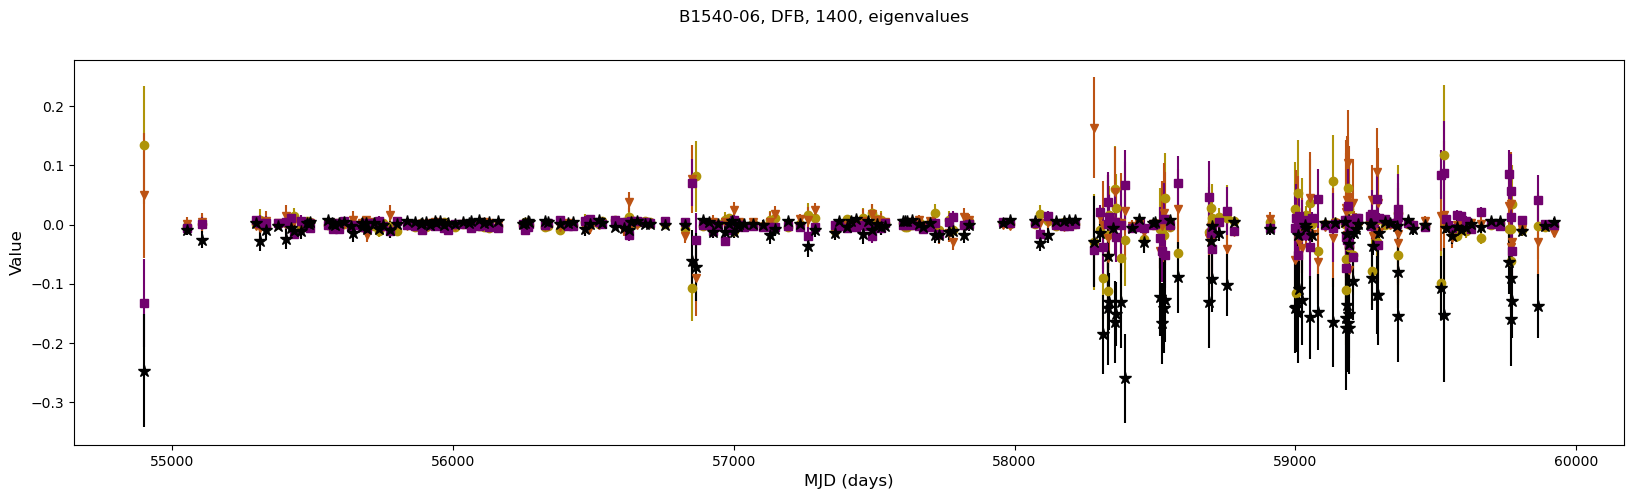

In [7]:
if exist_BE:
    with plt.style.context(plot_style):
        plt.clf()
        fig = plt.figure(figsize=(20, 5))
        fig.suptitle("{}, {}, {}, eigenvalues".format(psr, BE, freq))
        ax1 = fig.gca()
        ax1.errorbar(BE_mjds, BE_eigval[:,3], yerr=BE_errs[:,3], fmt='o', ecolor=c4, mec=c4, mfc=c4)
        ax1.errorbar(BE_mjds, BE_eigval[:,2], yerr=BE_errs[:,2], fmt='v', ecolor=c3, mec=c3, mfc=c3)
        ax1.errorbar(BE_mjds, BE_eigval[:,1], yerr=BE_errs[:,1], fmt='s', ecolor=c2, mec=c2, mfc=c2)
        ax1.errorbar(BE_mjds, BE_eigval[:,0], yerr=BE_errs[:,0], fmt='*', ecolor=c1, mec=c1, mfc=c1, ms=9)
        ax1.set_xlabel('MJD (days)', fontsize=12)
        ax1.set_ylabel('Value', fontsize=12)


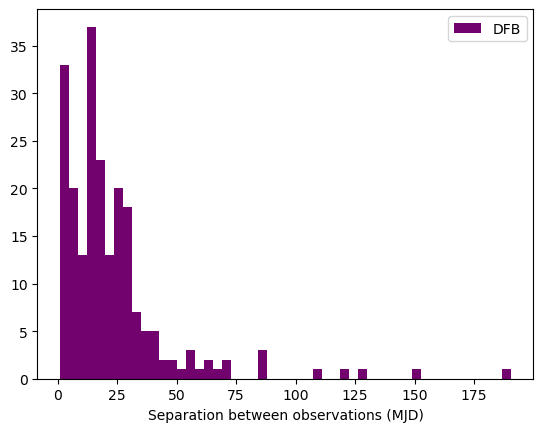

In [8]:
# plot the lag between consecutive observations
# if there are too many large gaps, the GP/MCMC can struggle
with plt.style.context(plot_style):
    plt.clf()
    if exist_BE:
        _ = plt.hist(BE_mjds[1:] - BE_mjds[:-1], bins=50, color=c2, label=BE)
        
    if exist_BE:
        plt.xlabel("Separation between observations (MJD)")
        plt.legend()
        plt.show()


In [9]:
# read in the MJDs from the nudot GP file to make alignment (for finding correlations) easier
if not os.path.exists(nudot_file):
    print("WARNING: File containing nu-dot GPs does not exist")
    BE_mjds_pred = None
else:
    nudot_mjds = np.loadtxt(nudot_file, unpack=True, usecols=(0,))
    avg_sep = np.mean(nudot_mjds[1:] - nudot_mjds[:-1]) # separation between nudot MJDs        
    if exist_BE:
        nudot_min = min(nudot_mjds)
        nudot_max = max(nudot_mjds)
        BE_min = min(BE_mjds)
        BE_max = max(BE_mjds)
        if nudot_min > BE_min:
            num_pre = int(np.ceil((nudot_min - BE_min)/avg_sep)) # number of points needed to fill
            new_min = nudot_min - avg_sep*num_pre # shift the minimum to use an integer
            pre_mjds = np.linspace(new_min, nudot_min, num_pre, endpoint=False)
            nudot_mjds = np.append(pre_mjds, nudot_mjds)
    
        if nudot_max < BE_max:
            num_post = int(np.ceil((BE_max - nudot_max)/avg_sep)) # number of points needed to fill
            new_max = nudot_max + avg_sep*num_post # shift the maximum to use an integer
            post_mjds = np.linspace(nudot_max, new_max, num_post, endpoint=False)
            nudot_mjds = np.append(nudot_mjds, post_mjds)

        BE_mjds_pred = nudot_mjds[nudot_mjds >= min(BE_mjds)-0.1]
        BE_mjds_pred = np.unique(BE_mjds_pred) # this shouldn't be necessary... why is it?
    
    print("The MJDs for the GP prediction span from {:.5f} to {:.5f} with an average separation of {:.3f}".format(min(nudot_mjds), max(nudot_mjds), avg_sep))
    if np.any(nudot_mjds != sorted(nudot_mjds)):
        print("Nudot MJDs are not sorted!!")
    

The MJDs for the GP prediction span from 46236.37397 to 59917.35342 with an average separation of 11.614


In [10]:
# if you don't want to re-run the MCMC and just want the final plots, use these lines to read in the final data
read_old = False
gp_file = os.path.join(data_dir, '{}_{}_gps_fin.npz'.format(psr, freq))
if read_old and os.path.exists(gp_file):
    with np.load(gp_file, allow_pickle=True) as d:
        if exist_BE and BE+'_mjds_pred' in d.keys():
            BE_mjds_pred = d[BE+'_mjds_pred']
            BE_pred_vars = d[BE+'_vars_pred']
            BE_pred_res = d[BE+'_res_pred']
        else:
            print("No {} arrays in npz file".format(BE))


Running GP for DFB data
The minimum length scale for DFB is 87.33
Subtracting 54901 from MJDs (will return true MJD values)
The initial parameter vector is [ 0.          6.21806919 -2.85589154 -0.03073399]
Running burn-in


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 103.29it/s]


Running second burn-in


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 105.38it/s]


Running production chain


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 118.00it/s]
The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [59.12959407 54.07378218 50.07217443 47.27987164]


The array of autocorrelation times is [59.12959407 54.07378218 50.07217443 47.27987164]


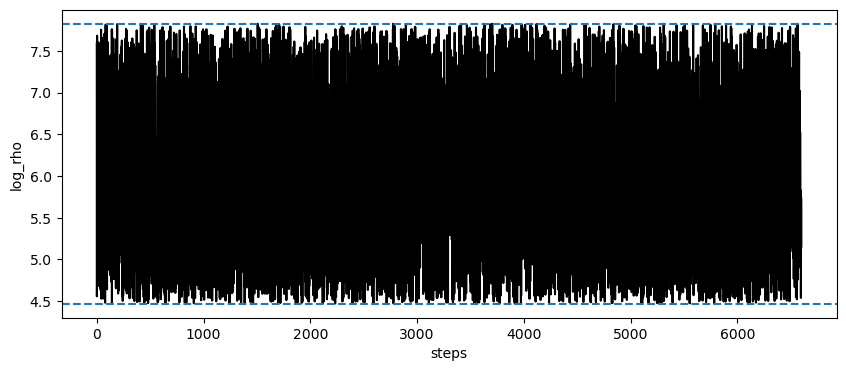

The bounds returned by the attribute are [(-15, 15), (4.469687986634042, 7.827507097479871), (-15, 15), (None, None)]
The 0th lower bound was breached, reaching a min. of -30.00
The 2nd lower bound was breached, reaching a min. of -30.00


<Figure size 640x480 with 0 Axes>

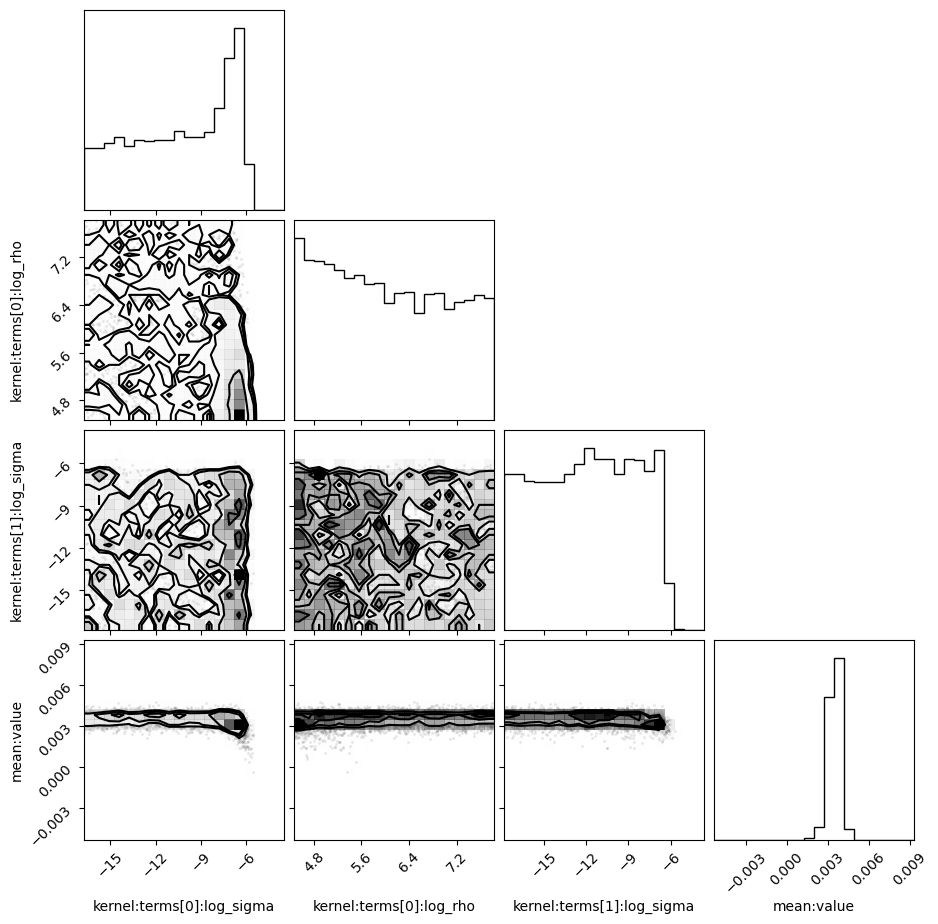

The initial parameter vector is [ 0.00000000e+00  6.21806919e+00 -3.80014497e+00  1.21362628e-04]
Running burn-in


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 93.69it/s]


Running second burn-in


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 91.85it/s]


Running production chain


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]
The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [38.99923919 36.52789335 39.52826972 36.15040863]


The array of autocorrelation times is [38.99923919 36.52789335 39.52826972 36.15040863]


<Figure size 640x480 with 0 Axes>

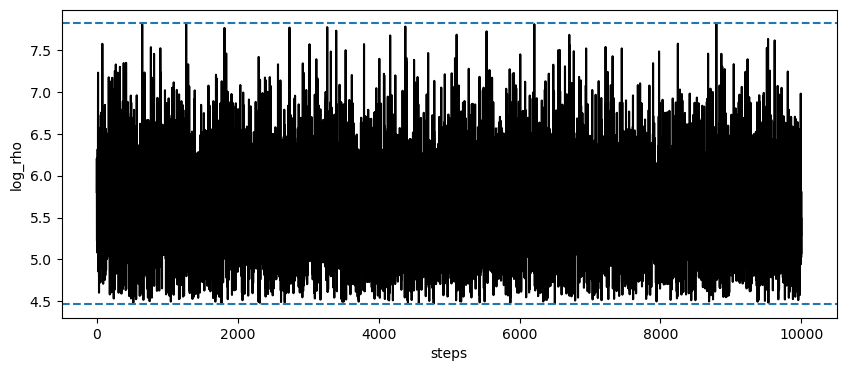

The bounds returned by the attribute are [(-15, 15), (4.469687986634042, 7.827507097479871), (-15, 15), (None, None)]
The 2nd lower bound was breached, reaching a min. of -30.00


<Figure size 640x480 with 0 Axes>

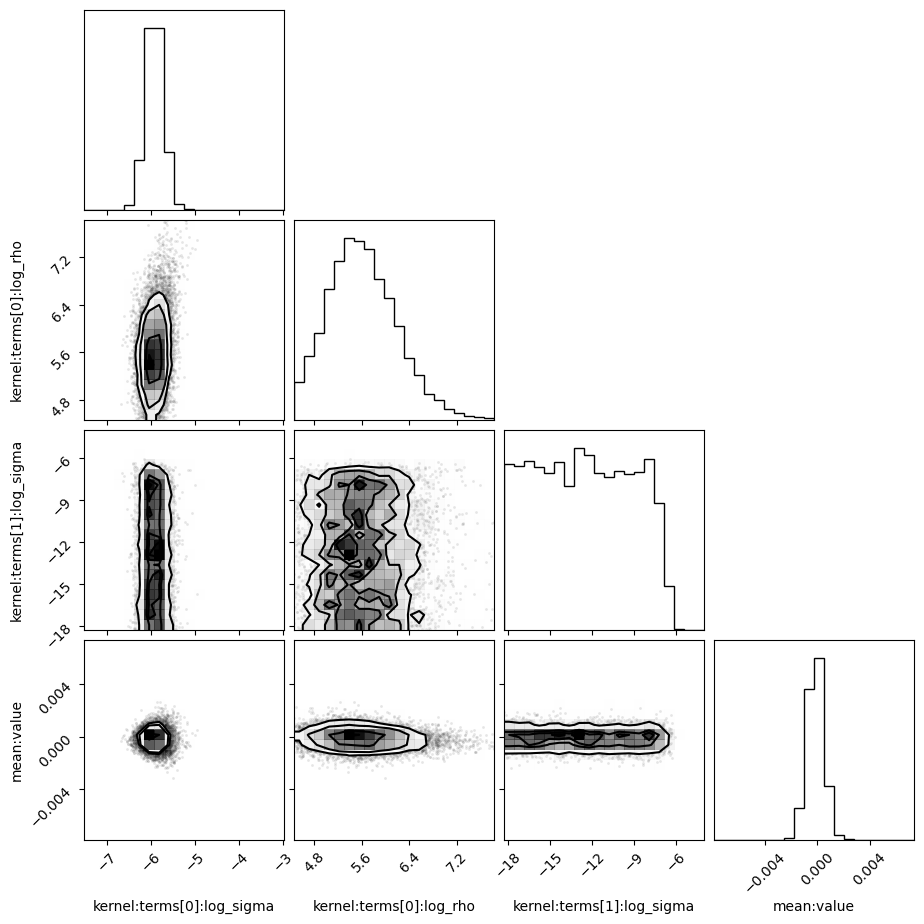

<Figure size 640x480 with 0 Axes>

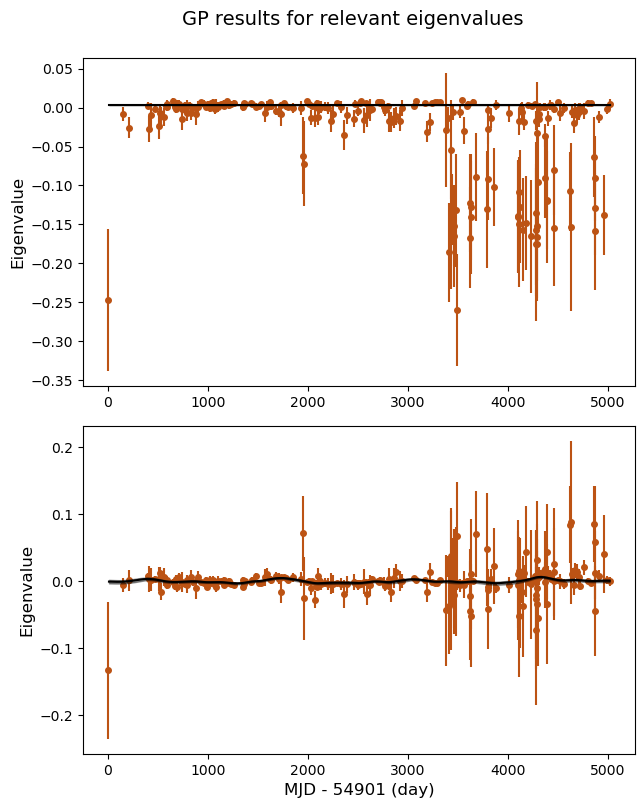

In [11]:
# finally, if you haven't read in the results in the last cell, this cell will run the GP for each eigenvalue
if exist_BE and BE+'_pred_res' not in locals():
    print("Running GP for {} data".format(BE))
    lags = BE_mjds[1:] - BE_mjds[:-1]
    pmin = np.percentile(lags, 97.5) # set the minimum bound for the length scale based on the separation between observations
    print("The minimum length scale for {} is {:.2f}".format(BE, pmin))
    mjd_range = BE_mjds[-1] - BE_mjds[0] # the maximum bound for the length scale is based on the total timespan (divided by 2 in the function call)
    kern_len = max(pmin*2, mjd_range/10)

    BE_pred_res, BE_pred_vars, BE_mjds_pred = run_each_gp(BE_eigval, BE_mjds, BE_errs, kern_len=kern_len, max_num=1, # adjust this number as necessary
                                                             prior_min=pmin, prior_max=0.5*mjd_range, mjds_pred=BE_mjds_pred,
                                                             burn_chain=100, prod_chain=1000, num_walkers=200, # these values can be adjusted but should work
                                                             plot_chains=True, plot_corner=True, plot_gps=True, mcmc=True, multi=True,
                                                             verb=True, bk_bgd=use_bk_bgd, gp_plotname=os.path.join(plots_dir, desc+'_gp_preds.png'.format(freq)))


In [1]:
# this cell will produce the waterfall plot of the reconstructed profiles
if exist_BE:
    if BE_ip_ex:
        bins = np.linspace(0, 1, num=len(BE_pca_mask), endpoint=False)
        ip_line = len(bins[np.logical_and(BE_mask, bins < 0.65)])
    else:
        ip_line = None
        
    plot_recon_profs(BE_mean, BE_eigvec, BE_mjds_pred, BE_pred_res, psr, mjds_real=BE_mjds, bk_bgd=use_bk_bgd,
                     sub_mean=True, savename=os.path.join(plots_dir, psr+'_BE_recon_wfall.png'),
                     ip_exist=BE_ip_ex, ip_line=ip_line)
    

SyntaxError: invalid syntax (732280865.py, line 7)

We want to save the arrays containing GP predicted values, so the following cells will check if an older file exists (which may contain arrays for different datasets), read that into a separate dictionary, and write both dictionaries to the '.npz' file. 

In [16]:
var_dict = {}
if exist_BE:
    var_dict[BE+'_mjds_pred'] = BE_mjds_pred
    var_dict[BE+'_res_pred'] = BE_pred_res
    var_dict[BE+'_vars_pred'] = BE_pred_vars


In [17]:
out_file = os.path.join(data_dir, '{}_{}_gps_fin.npz'.format(psr, freq))
old_dict = {}
if os.path.exists(out_file):
    with np.load(out_file, allow_pickle=True) as f:
        for key in f.keys():
            if key not in var_dict.keys():
                old_dict[key] = f[key]
            else:
                print("Replacing an older value for "+key)
                
np.savez(out_file, **var_dict, **old_dict)


Replacing an older value for DFB_mjds_pred
Replacing an older value for DFB_res_pred
Replacing an older value for DFB_vars_pred
